In [1]:
%matplotlib inline
%run ../../path_import.py
from plots import *
from training_reparam import *
from eubo import *
from model_reparam import *

import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [2]:
data_path = "../gmm_dataset_c5k"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()
_, N, D = Data.shape
K = 3 ## number of clusters
## Model Parameters
MCMC_SIZE = 10
SAMPLE_SIZE = 10
NUM_HIDDEN_LOCAL = 32
## Training Parameters
BATCH_SIZE = 20
NUM_EPOCHS = 300
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
PATH = 'ag-pr-%dsteps-%dsamples' % (MCMC_SIZE, SAMPLE_SIZE)

DEVICE = torch.device('cuda:0')

In [3]:
# initialization
enc_z = Gibbs_z(K, CUDA, DEVICE)
enc_eta = Enc_eta(K, D, CUDA, DEVICE)
if CUDA:
    enc_eta.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(enc_eta.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [4]:
# enc_eta.load_state_dict(torch.load('../weights/enc-eta-%s' + PATH))

In [5]:
RESAMPLE = True
DETACH=True
train_cfz_reparam(Eubo_cfz_pr_eta, enc_eta, enc_z, optimizer, Data, K, NUM_EPOCHS, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE, PATH, CUDA, DEVICE, RESAMPLE=RESAMPLE, DETACH=DETACH)

epoch=0, symKL=4403.509, EUBO=-425.154, ELBO=-5233.004, ESS=1.411 (38s)
epoch=1, symKL=3885.787, EUBO=-293.206, ELBO=-4585.488, ESS=1.421 (37s)
epoch=2, symKL=3450.980, EUBO=-180.875, ELBO=-4036.106, ESS=1.433 (37s)
epoch=3, symKL=3069.682, EUBO=-49.417, ELBO=-3525.480, ESS=1.445 (38s)
epoch=4, symKL=2747.857, EUBO=47.438, ELBO=-3103.916, ESS=1.459 (38s)
epoch=5, symKL=2493.538, EUBO=146.014, ELBO=-2752.049, ESS=1.472 (37s)
epoch=6, symKL=2300.233, EUBO=232.564, ELBO=-2472.335, ESS=1.485 (37s)
epoch=7, symKL=2133.008, EUBO=306.284, ELBO=-2231.826, ESS=1.501 (37s)
epoch=8, symKL=2006.949, EUBO=370.859, ELBO=-2040.398, ESS=1.522 (37s)
epoch=9, symKL=1907.203, EUBO=426.666, ELBO=-1887.380, ESS=1.538 (37s)
epoch=10, symKL=1814.824, EUBO=464.945, ELBO=-1754.126, ESS=1.555 (28s)
epoch=11, symKL=1742.348, EUBO=499.008, ELBO=-1648.622, ESS=1.574 (25s)
epoch=12, symKL=1684.921, EUBO=530.262, ELBO=-1559.946, ESS=1.592 (35s)
epoch=13, symKL=1636.575, EUBO=555.075, ELBO=-1486.763, ESS=1.611 (37s)


In [6]:
torch.save(enc_eta.state_dict(), '../weights/enc-eta-%s' + PATH)

In [7]:
BATCH_SIZE_TEST = 50
RESAMPLE= False
obs, q_eta, q_z, symkl_test, eubo_test, elbo_test = test(Eubo_cfz_pr_eta, enc_eta, enc_z, Data, K, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, RESAMPLE=RESAMPLE)

CPU times: user 2.78 s, sys: 43.1 ms, total: 2.82 s
Wall time: 2.47 s


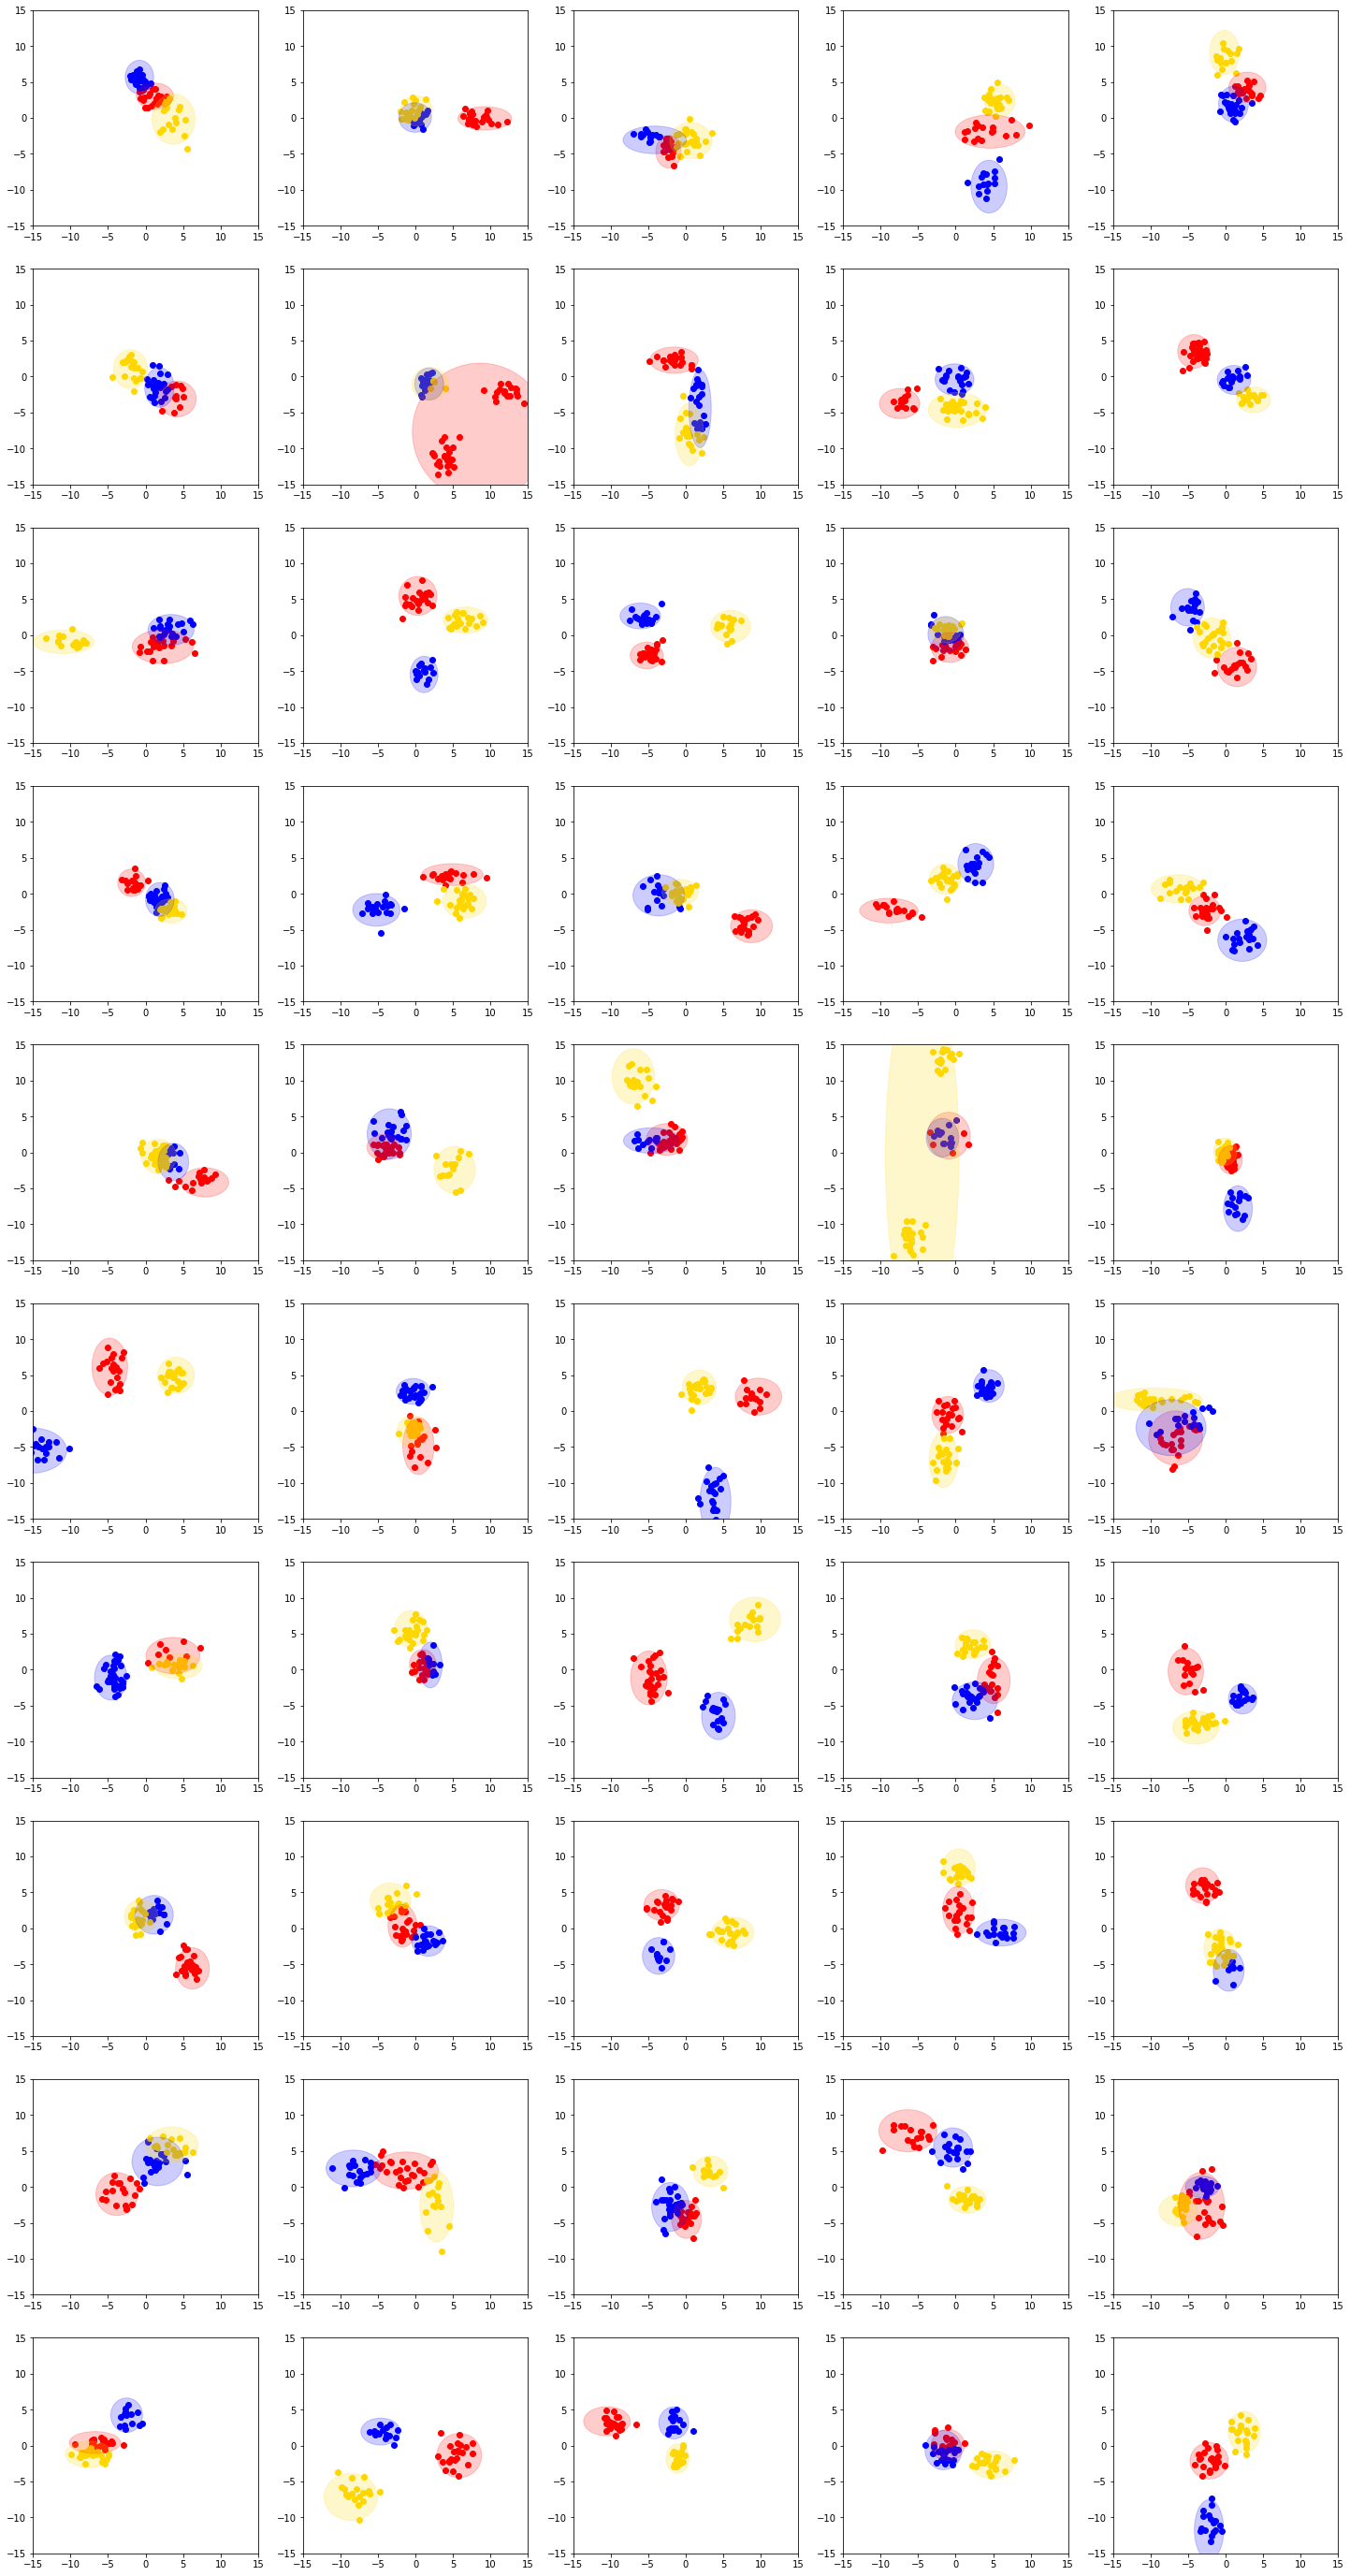

In [8]:
%time plot_samples(obs, q_eta, q_z, PATH)

In [9]:
incremental_gap = symkl_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

Text(0.5, 0, 'Steps')

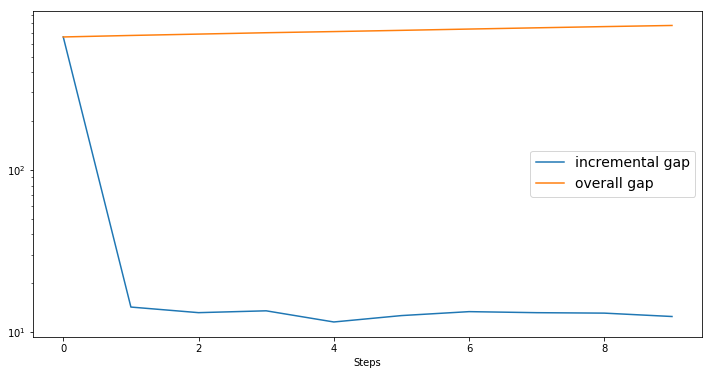

In [10]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')

In [11]:
incremental_gap

array([659.98816  ,  14.237356 ,  13.149535 ,  13.497112 ,  11.518957 ,
        12.613475 ,  13.340653 ,  13.144923 ,  13.0606985,  12.449516 ],
      dtype=float32)